# How hip are the hipsters? An astrophysicist analyzes last.fm data

We're going to query thousands of last.fm profiles and see if there's a specific correlation in "what" music people listen to vs. "how" they listen their music.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import copy
from glob import glob
import requests
import urllib

from config import api_key

#import urllib.request as request
#import urllib.parse as parse

In [2]:
def get_top_lastfm_artist(top_artist):
    params = {
        "method": "artist.getInfo",
        "artist": top_artist,
        "period": "overall",
        "format": "json",
        "api_key": api_key
    }
    res = requests.get("http://ws.audioscrobbler.com/2.0/", params=params).json()
    return int(res["artist"]["stats"]["listeners"]), int(res["artist"]["stats"]["playcount"])

def try_float(x):
    try:
        xx = float(x)
        return xx
    except ValueError:
        return np.nan

def load_all_artist_info():
    all_artist_info = {}
    
    for line in open('artists.txt','r'):
        artist, playcount, listeners, mainstreamness = line.split("|||")
        try:
            all_artist_info[artist.strip()] = {'artist_playcount': try_float(playcount.strip()),\
                                   'listeners': try_float(listeners.strip()), \
                                   'mainstreamness':try_float(mainstreamness.strip())}
        except KeyError:
            all_artist_info[artist.strip()] = {'artist_playcount': np.nan,\
                                   'listeners': np.nan, \
                                   'mainstreamness': np.nan}
    return all_artist_info


MAX_LISTENERS, MAX_PLAYCOUNT = get_top_lastfm_artist("Coldplay")



class user(object):
    
    def __init__(self, username):
        
        self.username = username
        self.user_response = None
        
        self.artists = {}
        
        self.mainstreamness = None
        self.gini = None
        self.user_total_playcount = None
    
    
    def compute_user_gini(self):
        if self.gini is None:
            playcount_list = [ a.user_playcount for a in self.artists.values()]
            sorted_list = sorted(playcount_list)
            if not sorted_list:
                return np.NaN
            else:
                height, area = 0, 0
                for value in sorted_list:
                    height += value
                    area += height - value / 2.
                fair_area = height * len(playcount_list) / 2.
                self.gini = (fair_area - area) / fair_area
        return self.gini
    
    
    def compute_user_mainstreamness(self):
        
        if self.mainstreamness is None:
            self.mainstreamness = sum([ a.user_playcount * a.mainstreamness \
                                       for a in self.artists.values() ])
            try:
                self.mainstreamness = self.mainstreamness / sum([ a.user_playcount \
                                        for a in self.artists.values() ])
            except ZeroDivisionError:
                self.mainstreamness = None
    
    
    def get_top_50_artists(self, write_to_file=False, read_from_file=False):
        
        assert not (write_to_file and read_from_file)
        
        self.user_total_playcount = 0
        
        if read_from_file:
            with open("./users/" + self.username + ".txt") as f:
                lines = f.readlines()
                for l in lines[:-1]:
                    artist_name, user_playcount = l.split(" ||| ")
                    self.artists[artist_name] = artist(artist_name, int(user_playcount.strip()))
                    
                self.user_total_playcount = int(lines[-1].split('playcount: ')[1])
                    
        else:
            creds_user = {
                "method": "user.getTopArtists",
                "user": self.username,
                "period": "overall",
                "format": "json",
                "limit": 50,
                "api_key": api_key
            }

            self.user_response = requests.get("http://ws.audioscrobbler.com/2.0/", params=creds_user).json()

            num = len(self.user_response["topartists"]["artist"])

            if write_to_file:
                f = open("./users/" + self.username + ".txt", "w")
            
            for i in range(num):
                artist_name = self.user_response["topartists"]["artist"][i]["name"]
                user_playcount = int(self.user_response["topartists"]["artist"][i]["playcount"])
                self.user_total_playcount += user_playcount
                self.artists[artist_name] = artist(artist_name, user_playcount)
                
                if write_to_file:
                    f.write(artist_name + " ||| " + str(user_playcount) + "\n")
                    
            if write_to_file:
                f.write("## playcount: " + str(self.user_total_playcount))
                f.close()
            
    def get_top_50_artists_info(self, read_from_dict=None):
        
        for a in self.artists.values(): a.get_artist_info(read_from_dict)  
    
    
    
class artist(object):

    def __init__(self, artist_name, user_playcount = None):

        self.artist_name = artist_name
        self.artist_response = None
        self.artist_data = None
        
        self.artist_playcount = None
        self.listeners = None
        self.mainstreamness = None
        
        self.user_playcount = user_playcount

    def get_artist_info(self, read_from_dict=None, write_to_file=False):

        if read_from_dict:
            self.artist_data = read_from_dict
            try:
                self.artist_playcount = self.artist_data[self.artist_name]['artist_playcount']
                self.listeners = self.artist_data[self.artist_name]['listeners']
                self.mainstreamness = self.artist_data[self.artist_name]['mainstreamness']
            except KeyError:
                self.artist_playcount = np.nan
                self.listeners = np.nan
                self.mainstreamness = np.nan
        
        else:
            creds_artist = {
                "method": "artist.getInfo",
                "artist": self.artist_name,
                "period": "overall",
                "format": "json",
                "api_key": api_key
            }

            self.artist_response = requests.get("http://ws.audioscrobbler.com/2.0/", params=creds_artist).json()

            
            try:
                self.artist_playcount = int(self.artist_response["artist"]["stats"]["playcount"])
                self.listeners = int(self.artist_response["artist"]["stats"]["listeners"])
            

                minval, maxval = 10000, MAX_LISTENERS

                if self.listeners > minval:
                    self.mainstreamness = (np.log(self.listeners) - np.log(minval)) / (np.log(maxval) - np.log(minval))
                else:
                    self.mainstreamness = 0.
                    
            except KeyError:
                self.playcount, self.listeners, self.mainstreamness = np.NaN, np.NaN, np.NaN
                
            
            if write_to_file:
                f = open("./artists.txt", "a")
#                if self.artist_name + " |||" not in open('./artists.txt').read():
                f.write(self.artist_name + " ||| " + str(self.artist_playcount) \
                                    + " ||| " + str(self.listeners) \
                                    + " ||| " + str(self.mainstreamness) + "\n")
                f.close()

First, we need a random sample of users. I do this by starting with a profile (e.g., my own "gravity_tractor"), selecting a random friend/follower, and saving their username. Then I do this for one of THEIR friends/followers, then and so on for some large number of iterations. I save every 4th user to prevent very strong correlations between friends' or friends-of-friends' musical taste.

There were times where this procedure looped back to an already queried user. In the end, I have a list of users and remove any duplicate entries.

The cell below generates this list of users.

## WARNING: TAKES A WHILE. SKIP IF YOU HAVE A LIST STORED SOMEWHERE

In [ ]:
newuser = olduser = "gravity_tractor"

#f = open("./users/usernames.txt", "w")

names = []

for i in range(20):
    params = {
        "method": "user.getFriends",
        "user": newuser,
        "format": "json",
        "limit": 500,
        "api_key": api_key
    }
    
    try:
        r = requests.get("http://ws.audioscrobbler.com/2.0/", params=params).json()
        rand = np.random.randint(0, len(r['friends']['user']))
        newuser = r['friends']['user'][rand]['name']
    except:
        print("### PROBLEM WITH ###", newuser)
        params['user'] = olduser
        newuser = olduser
        r = requests.get("http://ws.audioscrobbler.com/2.0/", params=params).json()
    
    if i%1==0:
#        f.write(newuser + "\n")
        print(newuser)
        if newuser in names:
            newuser = np.random.choice(names)
        else: 
            names.append(newuser)
    
#f.close()

Below, I'm going to define some classes for last.fm artists and last.fm users. I'll explain what each attribute or method does as they're called.

In [3]:
from ipywidgets import FloatProgress
from IPython.display import display

## Download user info directly from last.fm (slow) or from files (fast)

The first thing we want to do is get a user's top 50 artists. This is a very slow process if we're querying information for thousands of last.fm users, even with the last.fm API. For the sake of being able to repeat this experiment, I stored every user's data in files corresponding to their usernames.

In the end, we get a dictionary that contains each username, their top 50 artists, and how many times they've listened to each artist.

In [4]:
user_info = {}
files = "\t".join(glob("./users/*.txt"))

with open("./usernames.txt") as f:
    usernames = list(map(lambda s: s.rstrip(), f.readlines()))
    
f = FloatProgress(min=0, max=len(usernames))
display(f)

rff = True
wtf = False

for i,u in enumerate(usernames):
    if rff and u in user_info:
            continue
    elif wtf:
        if "/users/"+u+".txt" in files:
            continue    
    else:
        try:
            uu = user(u)
            uu.get_top_50_artists(read_from_file=rff)
            user_info[u] = uu
        except ConnectionError:
            user_info.pop(u, None)
    f.value = i

FloatProgress(value=0.0, max=17961.0)

## Get a list of all unique artists, then get their info (playcount, listeners, mainstream rating)

Next, we want to get a sense of how mainstream all of the artists are. So, we create a list of *unique* artists.

In [5]:
artists = list(set([ a for u in user_info.keys() for a in list(user_info[u].artists.keys()) ]))

The next cell prints the number of unique artists from everyone's profiles.

In [6]:
print(len(artists))

78442


I also have all the artist information stored locally. Let's load that real quick.

In [7]:
artist_info = load_all_artist_info()

Now let's append all of the user data with information on their top 50 artists.

In [9]:
for u in user_info:
    user_info[u].get_top_50_artists_info(read_from_dict=artist_info)

## Computing a user's mainstream factor and Gini coefficients

With both the user and artist information, we can compute each user's mainstream factor and their Gini coefficients.

In [10]:
data = []

In [11]:
for u in user_info:
    user_info[u].compute_user_mainstreamness()
    user_info[u].compute_user_gini()
    data.append([user_info[u].mainstreamness, user_info[u].gini, user_info[u].user_total_playcount, u])
    
len(data)

17961

Only consider users with more than 500 total plays and Gini coefficients not equal to 0.

In [12]:
data_clean = [ d for d in data if np.nan not in d ]
data_clean = [ d for d in data_clean if d[2]>500 and d[1]!=0 ]

In [13]:
data_T = list(map(list, zip(*data_clean)))
mainstreamnesses = data_T[0]
ginis = data_T[1]
playcounts = data_T[2]

In [14]:
bins_x = np.linspace(0, 1, 21)
bins_y = np.linspace(0, 1, 21)

digitized = np.digitize(mainstreamnesses, bins_x)

means_x = [np.array(mainstreamnesses)[digitized == i].mean() for i in range(1, len(bins_x))]
means_y = [np.array(ginis)[digitized == i].mean() for i in range(1, len(bins_x))]

per_y_15 = [np.percentile(np.array(ginis)[digitized == i], 15) for i in range(1,19)] + [np.NaN, np.NaN]
per_y_85 = [np.percentile(np.array(ginis)[digitized == i], 85) for i in range(1,19)] + [np.NaN, np.NaN]

/Users/benelson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice.
  
/Users/benelson/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/benelson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys


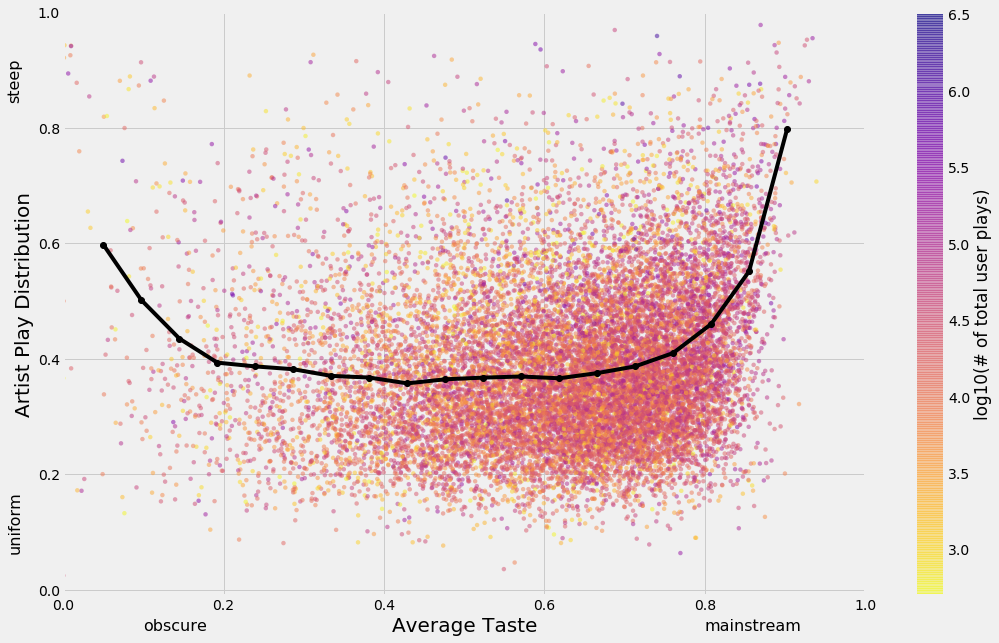

In [16]:
plt.figure(figsize=(16,10))
plt.style.use('fivethirtyeight')
cm = plt.cm.get_cmap('plasma_r')

sc = plt.scatter(mainstreamnesses, ginis, c=np.log10(playcounts), \
                 s=20, alpha=0.5, cmap=cm, edgecolors="None", picker=True)
#mpldatacursor.datacursor(sc)
plt.colorbar(sc, label="log10(# of total user plays)")
plt.plot(np.linspace(0.05,0.95,20), means_y, 'o-', color='black')
plt.xlabel("Average Taste", fontsize=20)
plt.ylabel("Artist Play Distribution", fontsize=20)
plt.xlim(0., 1.)
plt.ylim(-0.01, 1.)

plt.text(0.1, -0.07, "obscure", fontsize=16)
plt.text(0.8, -0.07, "mainstream", fontsize=16)
plt.text(-0.07, 0.15, "uniform", fontsize=16, rotation=90)
plt.text(-0.07, 0.9, "steep", fontsize=16, rotation=90)

plt.show()

In [ ]:
#ddd = [d for d in data_clean if d[0] > 0.85 and d[1] < 0.2 ]

## Examples for individual users

Here's how to show where individual users reside in this figure.

In [19]:
users = {}

for username in ['gravity_tractor','NMH1998', 'arthurcormorant', 'michiganwookie', 'rskasch']:
    uu = user(username)
    uu.get_top_50_artists()
    uu.get_top_50_artists_info()
    uu.compute_user_mainstreamness()
    uu.compute_user_gini()
    users[username] = uu
    print('done with ' + username)

#    user_data = { key: uu.artists[key].user_playcount for key in uu.artists.keys() }
#    user_artists = list(sorted(user_data, key=user_data.__getitem__, reverse=True))
    
#    print(username, "mainstreamness:", uu.mainstreamness)
#    print(username, "play distribution:", uu.gini)
    
#    plt.style.use('fivethirtyeight')
#    xs = np.linspace(1.,50.,50)
#    plt.bar(xs, sorted([user_data[key] for key in user_data.keys()], reverse=True))
#    plt.xticks(xs, user_artists, rotation=90)
#    plt.title(username)
#    plt.ylabel("Play Count")
#    plt.xlim(0.,20.5)
#    plt.show()

done with gravity_tractor
done with NMH1998
done with arthurcormorant
done with michiganwookie
done with rskasch


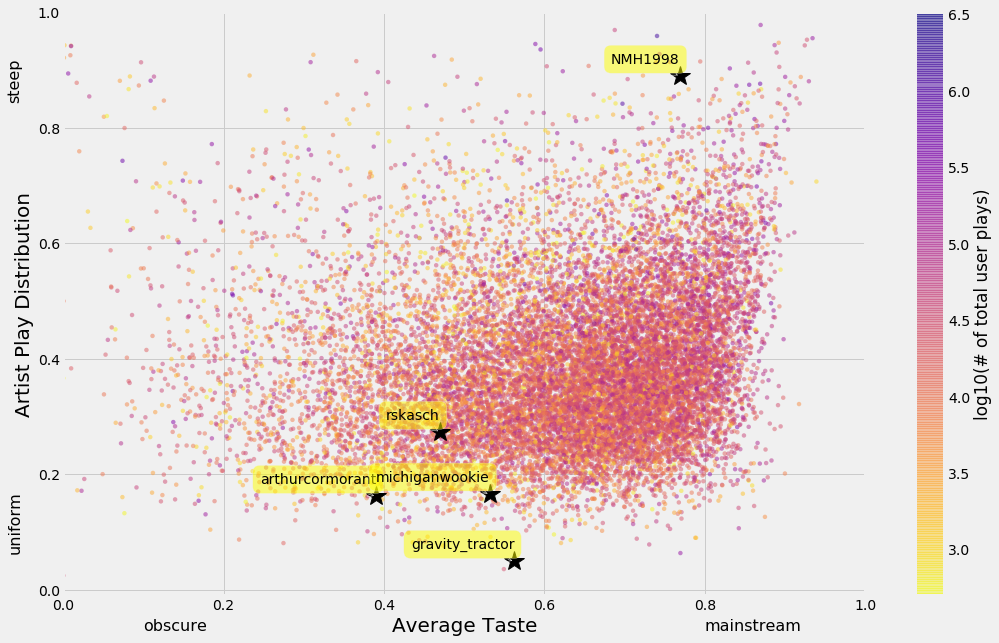

In [20]:
plt.figure(figsize=(16,10))
plt.style.use('fivethirtyeight')
cm = plt.cm.get_cmap('plasma_r')

for u in users:
    plt.plot(users[u].mainstreamness, users[u].gini, '*', color='black', markersize=20)
    plt.annotate(
        u,
        xy=(users[u].mainstreamness, users[u].gini), xytext=(0., 10),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
sc = plt.scatter(mainstreamnesses, ginis, c=np.log10(playcounts), \
                 s=20, alpha=0.5, cmap=cm, edgecolors="None", picker=True)
plt.colorbar(sc, label="log10(# of total user plays)")
plt.xlabel("Average Taste", fontsize=20)
plt.ylabel("Artist Play Distribution", fontsize=20)
plt.xlim(0., 1.)
plt.ylim(-0.01, 1.)

plt.text(0.1, -0.07, "obscure", fontsize=16)
plt.text(0.8, -0.07, "mainstream", fontsize=16)
plt.text(-0.07, 0.15, "uniform", fontsize=16, rotation=90)
plt.text(-0.07, 0.9, "steep", fontsize=16, rotation=90)

plt.show()